# Zaawansowane techniki analizy skupień wariant 4


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Konfiguracja wykresów
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Ładowanie danych bezpośrednio z repozytorium UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
try:
    df = pd.read_csv(url)
    print("Dane załadowane pomyślnie.")
except Exception as e:
    print(f"Błąd pobierania danych: {e}")

# Wyświetlenie pierwszych wierszy
print(df.head())

# Usunięcie kolumn kategorycznych 'Channel' i 'Region', 
# aby skupić się na grupowaniu na podstawie wydatków (Fresh, Milk, Grocery, etc.)
X_raw = df.drop(['Channel', 'Region'], axis=1)

# Statystyki opisowe przed skalowaniem
print("\nStatystyki danych:")
print(X_raw.describe())

Dane załadowane pomyślnie.
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

Statystyki danych:
               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750

# Komórka 2: Standaryzacja Danych
### Algorytmy oparte na odległościach (jak K-means czy DBSCAN) są wrażliwe na skalę danych. Jeśli jedna kategoria ma wartości rzędu 100 000, a inna 100, algorytm zdominuje ta pierwsza. Dlatego należy użyć StandardScaler

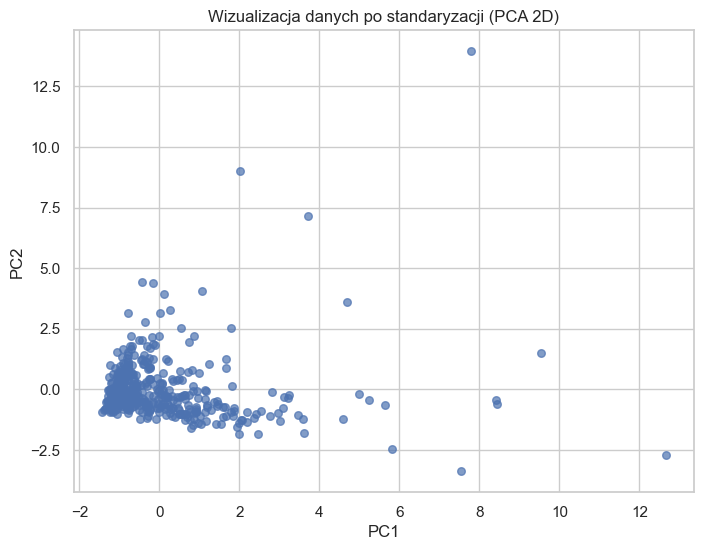

In [ ]:
# Standaryzacja danych (średnia = 0, odchylenie standardowe = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Redukcja wymiarowości do 2D za pomocą PCA tylko do celów wizualizacji
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=30, alpha=0.7)
plt.title("Wizualizacja danych po standaryzacji (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Komórka 3: K-means – Dobór liczby skupień (Metoda Łokcia i Silhouette)

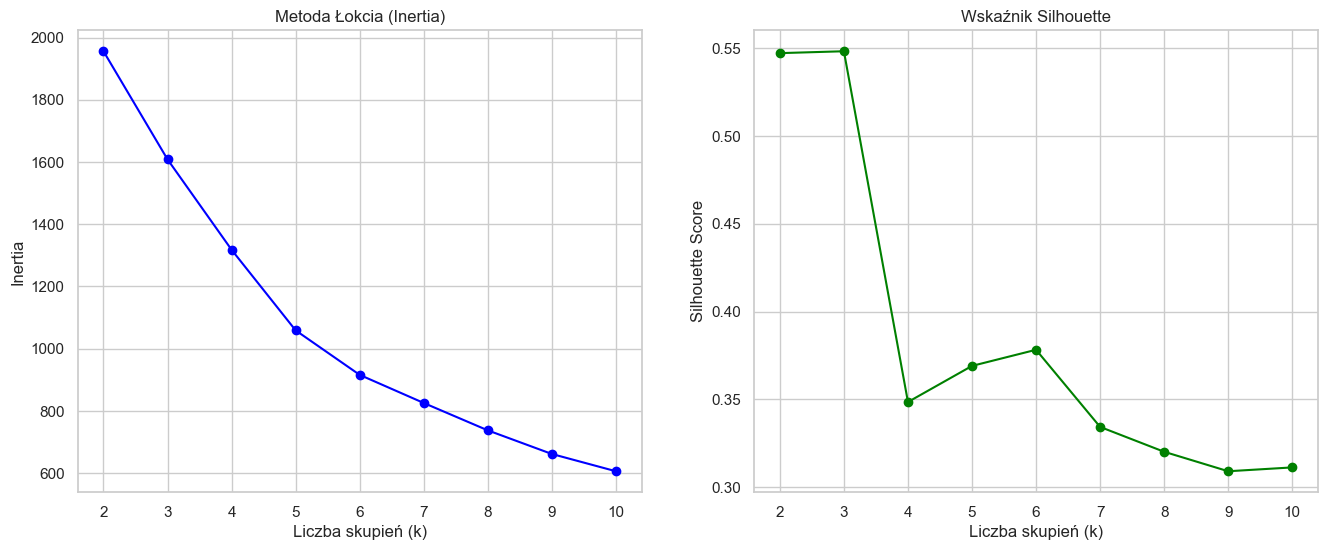

In [3]:
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Wykresy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Metoda łokcia
ax1.plot(k_range, inertia, marker='o', color='blue')
ax1.set_title('Metoda Łokcia (Inertia)')
ax1.set_xlabel('Liczba skupień (k)')
ax1.set_ylabel('Inertia')

# Wskaźnik Silhouette
ax2.plot(k_range, silhouette_scores, marker='o', color='green')
ax2.set_title('Wskaźnik Silhouette')
ax2.set_xlabel('Liczba skupień (k)')
ax2.set_ylabel('Silhouette Score')

plt.show()

# Komórka 4: K-means – Finalny Model
### Na podstawie powyższych wykresów wybrano optymalne k (zazwyczaj dla tego zbioru rozsądne jest k=3 lub k=5). Przyjeto więc k=5 dla zróżnicowania grup klientów.

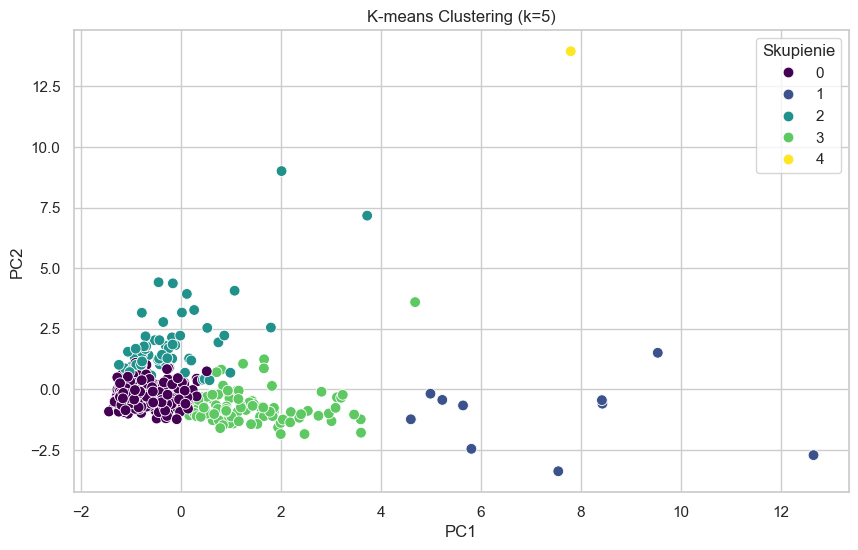

K-means Silhouette: 0.369


In [4]:
# Ustawiamy wybraną liczbę skupień
best_k = 5 

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

# Wizualizacja na rzucie PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_kmeans, palette='viridis', s=60)
plt.title(f'K-means Clustering (k={best_k})')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Skupienie')
plt.show()

# Ocena
print(f"K-means Silhouette: {silhouette_score(X_scaled, y_kmeans):.3f}")

# Komórka 5: DBSCAN – Grupowanie oparte na gęstości
### DBSCAN jest trudniejszy w tym zbiorze, ponieważ gęstość danych jest bardzo zróżnicowana (wiele punktów skupionych blisko środka). Należy dobrać eps eksperymentalnie.

Liczba skupień: 1
Liczba punktów szumu: 13


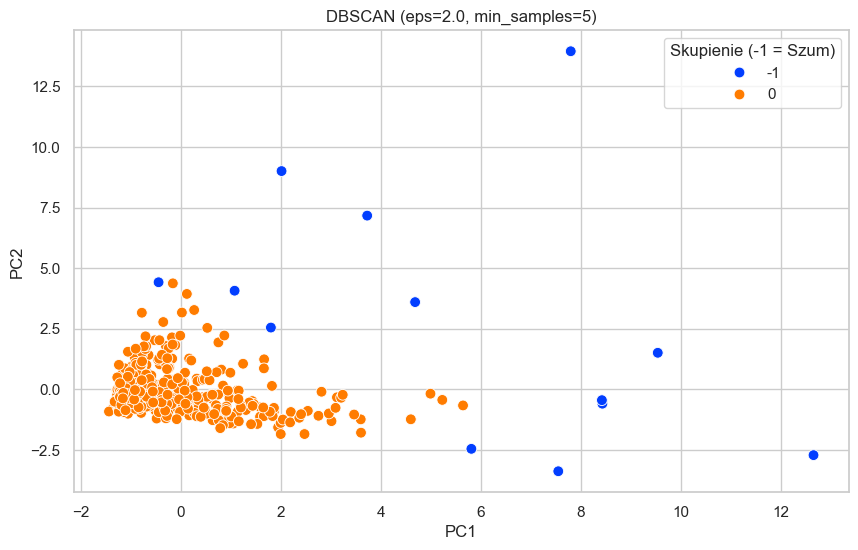

In [5]:
# Próba doboru parametrów. Zwiększamy eps, ponieważ dane są wielowymiarowe.
eps_val = 2.0
min_samples_val = 5

dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
y_dbscan = dbscan.fit_predict(X_scaled)

# Liczba skupień (bez szumu oznaczonego jako -1)
n_clusters_db = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
n_noise = list(y_dbscan).count(-1)

print(f"Liczba skupień: {n_clusters_db}")
print(f"Liczba punktów szumu: {n_noise}")

# Wizualizacja
plt.figure(figsize=(10, 6))
# Punkty szumu na szaro, reszta kolorami
palette = sns.color_palette("bright", len(set(y_dbscan)))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_dbscan, palette=palette, s=60)
plt.title(f'DBSCAN (eps={eps_val}, min_samples={min_samples_val})')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Skupienie (-1 = Szum)')
plt.show()

# Komórka 6: Agglomerative Clustering (Hierarchiczne)

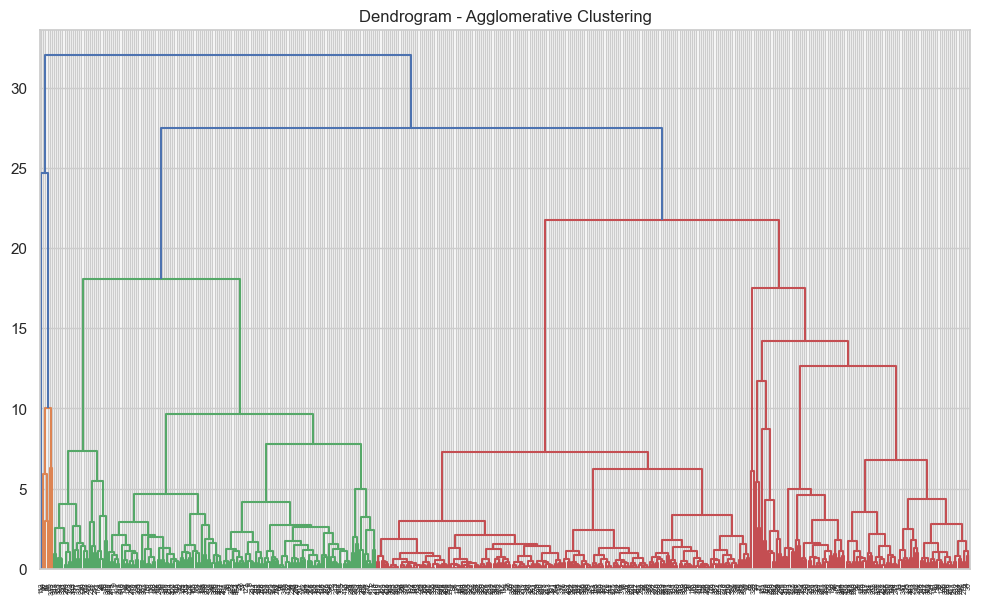

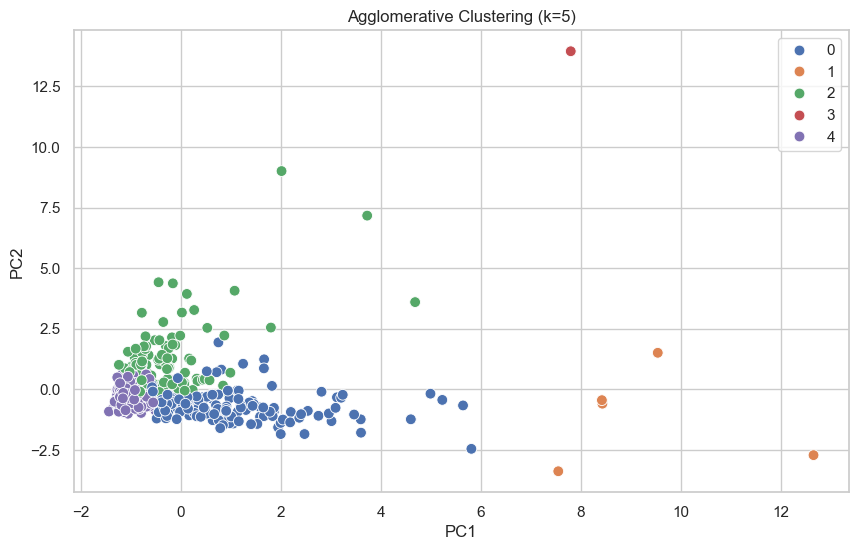

In [6]:
# Rysowanie dendrogramu
plt.figure(figsize=(12, 7))
plt.title("Dendrogram - Agglomerative Clustering")
dendro = dendrogram(linkage(X_scaled, method='ward'))
plt.show()

# Trenowanie modelu (przyjmujemy k=5 dla porównania z K-means)
agg_clust = AgglomerativeClustering(n_clusters=5, linkage='ward')
y_agg = agg_clust.fit_predict(X_scaled)

# Wizualizacja
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_agg, palette='deep', s=60)
plt.title('Agglomerative Clustering (k=5)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Komórka 7: Porównanie wyników

In [7]:
results = []

algorithms = [
    ('K-means', y_kmeans),
    ('DBSCAN', y_dbscan),
    ('Agglomerative', y_agg)
]

print(f"{'Algorytm':<15} | {'Silhouette':<10} | {'Calinski-Harabasz':<18} | {'Davies-Bouldin':<15}")
print("-" * 65)

for name, labels in algorithms:
    # Pomijamy ocenę dla DBSCAN jeśli wykrył tylko 1 klaster lub sam szum
    if len(set(labels)) > 1:
        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        print(f"{name:<15} | {sil:<10.3f} | {ch:<18.1f} | {db:<15.3f}")
    else:
        print(f"{name:<15} | {'Brak wystarczającej liczby skupień do oceny':<40}")

print("-" * 65)
print("\nInterpretacja:")
print("Silhouette: Im bliżej 1, tym lepiej.")
print("Calinski-Harabasz: Im wyższa wartość, tym lepiej.")
print("Davies-Bouldin: Im niższa wartość, tym lepiej.")

Algorytm        | Silhouette | Calinski-Harabasz  | Davies-Bouldin 
-----------------------------------------------------------------
K-means         | 0.369      | 162.4              | 0.912          
DBSCAN          | 0.749      | 110.4              | 1.368          
Agglomerative   | 0.240      | 128.6              | 0.973          
-----------------------------------------------------------------

Interpretacja:
Silhouette: Im bliżej 1, tym lepiej.
Calinski-Harabasz: Im wyższa wartość, tym lepiej.
Davies-Bouldin: Im niższa wartość, tym lepiej.
